## Projeto 3- Traveling salesman em gpu - Paulo Tozzo

## O Problema

O problema do caixeiro-viajante é um problema comum na área de logísticas, ele é basicamente: dado n pontos qual é o menor caminho que percorra todos esses pontos?. Esse problema é classificado como NP-completo, sua solução é custosa em relação ao tempo. Portanto uma solução (2-opt) foi implementado usando uma gpu para realização de cálculos, essa implementação foi comparada com uma versão paralelizada  e também com uma versão que chuta respostas, essa também usa a gpu para realizar os cálculos.

In [1]:
import sys
import subprocess
from subprocess import PIPE
import numpy as np
import matplotlib.pyplot as plt

## Organização do codigo
O algoritmo no geral é simples, ele usa um kernel cuda para pré-calcular todas as distâncias possíveis e depois usa outro kernel em cuda que foi implementado o 2-opt, esse cria caminhos randomicamente , e depois mudam a sequência dos pontos até não ter melhora no custo total, o algoritmo randômico só faz a primeira parte do 2-opt ou seja só randomiza a lista.

## Descrição dos testes
Foi realizado  testes 3 de desempenho, comparado a solução em gpu e a paralela vendo também o tempo que a gpu gasta realmente calculando a solução vs o tempo que ela gasta de overhead. Para medir o tempo foi usado `std::chrono::high_resolution_clock` para o algoritmo em paralelo e evento e `cudaEvent` para o codigo cuda.Para diminuir a variação de tempo os testes os testes foram executados múltiplas vezes e foi feita a média. O computador que executou os testes têm como hardware relevante:
processador i7-8550U CPU @ 1.80GHz e
GeForce MX150.

Deve ser notado também que apesar que simplesmente gerar sequências aleatórias é mais rápido que calcular o 2-opt, porem esse gera solução muito melhores, principalmente para números grandes. Os dois 2-opt (em paralelo e em gpu) tem resultados semelhantes, só não são iguais porque a maneira que os números aleatórios são gerados é diferente.

É esperado que os arquivos compilados estajam em uma pasta chamada build.


## teste 1
teste simples que em que os três pontos formam um triângulo retângulo.


In [2]:
def convert_cut(time):
    if (time[-2:] == "ms"): #convert
        return (float(time[:-2])/1000)
    try:
        return float(time[:-1])
    except:
        sys.exit("tempo não reconhecido: "+str(time))

def get_time(data):
    data = data.splitlines()
    total = float(((data[1][:])).split()[-1])/1000#total time
    solver = (((data[5][:])).split()[3])#GPU solver time
    
    solver = convert_cut(solver)
    return total, solver

In [3]:
with open('teste1.txt', 'r') as file:
    data = file.read().replace('\n', ' ')
    data = str.encode(data)

time_total = [];
time_solver = [];

for i in range(1):
    main = subprocess.run(["nvprof","./build/2opt-sol"],input = data,stderr=PIPE,stdout=PIPE)
    
    total ,solver = get_time((main.stderr).decode("utf-8"))
    
    
    
    time_total.append(total)
    time_solver.append(solver)
    
best_sol = ((main.stdout).decode("utf-8")).split()[0]#sempre vai ser o mesmo

In [4]:
time_total_r = [];
time_solver_r = [];

for i in range(1):
    main_r = subprocess.run(["nvprof","./build/random-sol"],input = data,stderr=PIPE,stdout=PIPE)
    
    total ,solver = get_time((main_r.stderr).decode("utf-8"))

    time_total_r.append(total)
    time_solver_r.append(solver)

best_r_sol = ((main_r.stdout).decode("utf-8")).split()[0]

In [5]:
time_para = [];

for i in range(1):
    main_para = subprocess.run(["build/opt_para"],input = data,stderr=PIPE,stdout=PIPE)

    time_para.append(float((main_para.stderr).decode("utf-8")))

    
best_para_sol = ((main_para.stdout).decode("utf-8")).split()[0]

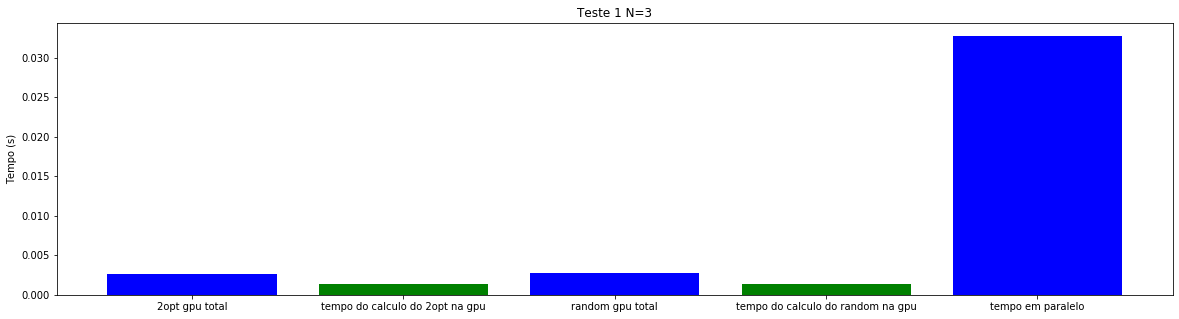

melhor solução: 2-opt 4, random-sol 4, opt_para 4


In [6]:
x = np.arange(5)
mean_list = [np.mean(time_total),np.mean(time_solver),np.mean(time_total_r),np.mean(time_solver_r),np.mean(time_para)]

fig, ax = plt.subplots(figsize=(20,5))
plt.bar(x, mean_list, color = ["blue", "green"])
plt.xticks(x, ["2opt gpu total","tempo do calculo do 2opt na gpu","random gpu total","tempo do calculo do random na gpu","tempo em paralelo"])
plt.ylabel("Tempo (s)")
plt.title("Teste 1 N=3")
plt.show()
print("melhor solução: 2-opt {0}, random-sol {1}, opt_para {2}".format(best_sol,best_r_sol,best_para_sol))

Podemos que nos códigos CUDA a maioria do tempo é perdida com o overhead do programa e que ela passa pouco tempo realmente calculando o resultado,porém mesmo assim é mais rápida que o código em paralelo. Podemos ver tambem que para um n pequeno o 2-opt tem a mesma solução que o random.

## teste 2
teste mais complexo que contem 15 pontos aleatoriamente gerados usando o programa "gerador.py". 

In [7]:
with open('teste5.txt', 'r') as file:
    data = file.read().replace('\n', ' ')
    data = str.encode(data)

time_total = [];
time_solver = [];

for i in range(50):
    main = subprocess.run(["nvprof","./build/2opt-sol"],input = data,stderr=PIPE,stdout=PIPE)
    
    total ,solver = get_time((main.stderr).decode("utf-8"))

    time_total.append(total)
    time_solver.append(solver)
    
time_total_r = [];
time_solver_r = [];

for i in range(50):
    main_r = subprocess.run(["nvprof","./build/random-sol"],input = data,stderr=PIPE,stdout=PIPE)
    
    total ,solver = get_time((main_r.stderr).decode("utf-8"))

    time_total_r.append(total)
    time_solver_r.append(solver)
    
time_para = [];

for i in range(25):
    main_para = subprocess.run(["build/opt_para"],input = data,stderr=PIPE,stdout=PIPE)

    time_para.append(float((main_para.stderr).decode("utf-8")))
    
best_sol = ((main.stdout).decode("utf-8")).split()[0]
best_r_sol = ((main_r.stdout).decode("utf-8")).split()[0]
best_para_sol = ((main_para.stdout).decode("utf-8")).split()[0]

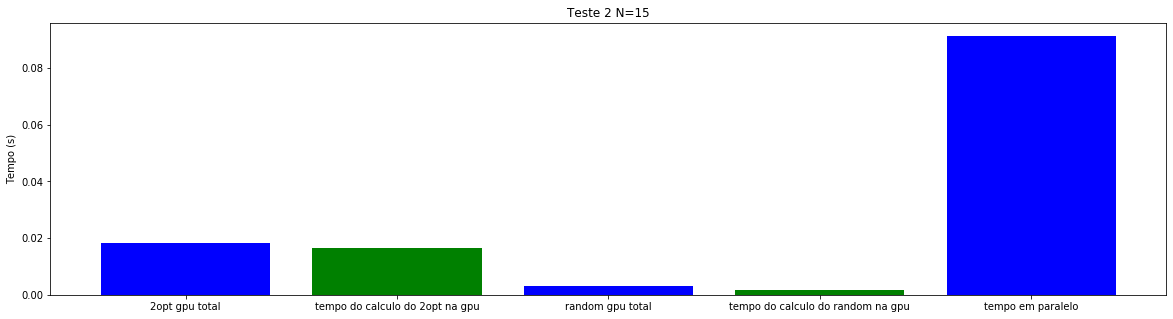

melhor solução: 2-opt 17078.7, random-sol 23628.3, opt_para 27742


In [8]:
x = np.arange(5)
mean_list = [np.mean(time_total),np.mean(time_solver),np.mean(time_total_r),np.mean(time_solver_r),np.mean(time_para)]

fig, ax = plt.subplots(figsize=(20,5))
plt.bar(x, mean_list, color = ["blue", "green"])
plt.xticks(x, ["2opt gpu total","tempo do calculo do 2opt na gpu","random gpu total","tempo do calculo do random na gpu","tempo em paralelo"])
plt.ylabel("Tempo (s)")
plt.title("Teste 2 N=15")
plt.show()
print("melhor solução: 2-opt {0}, random-sol {1}, opt_para {2}".format(best_sol,best_r_sol,best_para_sol))

Podemos ver novamente que o cálculo em gpu é mais rápido. Esta c

## teste 3
teste que contem 100 pontos aleatoriamente gerados usando o programa "gerador.py". Esse texto não contém a comparação com o em paralelo, já que para esse nível de dados ele seria muito lento. O primeiro gŕafico desse teste está em escala logarítmica. 

In [10]:
with open('large.txt', 'r') as file:
    data = file.read().replace('\n', ' ')
    data = str.encode(data)

time_total = [];
time_solver = [];

for i in range(1):
    main = subprocess.run(["nvprof","./build/2opt-sol"],input = data,stderr=PIPE,stdout=PIPE)
    
    total ,solver = get_time((main.stderr).decode("utf-8"))

    time_total.append(total)
    time_solver.append(solver)
    
time_total_r = [];
time_solver_r = [];

for i in range(2):
    main_r = subprocess.run(["nvprof","./build/random-sol"],input = data,stderr=PIPE,stdout=PIPE)
    
    total ,solver = get_time((main_r.stderr).decode("utf-8"))

    time_total_r.append(total)
    time_solver_r.append(solver)
    

best_sol = ((main.stdout).decode("utf-8")).split()[0]
best_r_sol = ((main_r.stdout).decode("utf-8")).split()[0]

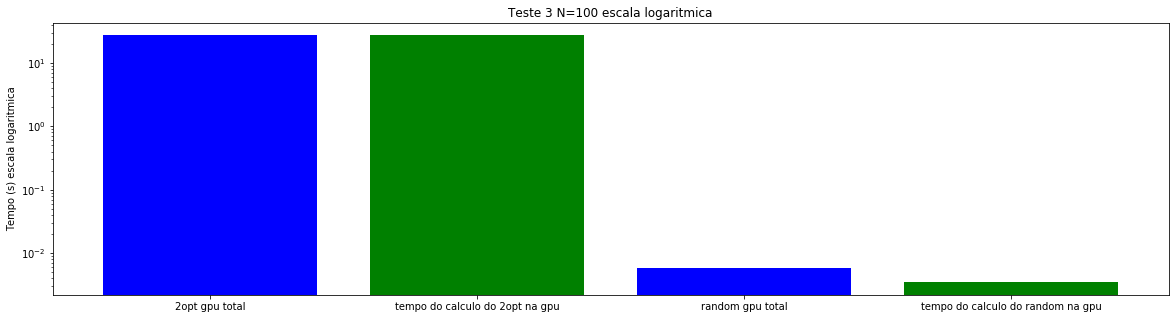

In [11]:
x = np.arange(4)
y = (np.sin(1.e-2*(x[:-1]-20))+3)**10
mean_list = [np.mean(time_total),np.mean(time_solver),np.mean(time_total_r),np.mean(time_solver_r)]

fig, ax = plt.subplots(figsize=(20,5))
plt.bar(x, mean_list, color = ["blue", "green"] , log=True)
plt.xticks(x, ["2opt gpu total","tempo do calculo do 2opt na gpu","random gpu total","tempo do calculo do random na gpu","tempo em paralelo"])
plt.ylabel("Tempo (s) escala logaritmica")
plt.title("Teste 3 N=100 escala logaritmica")
plt.show()


Abaixo podemos ver os mesmo resultados, mas esses não estão em escala logarítmica.

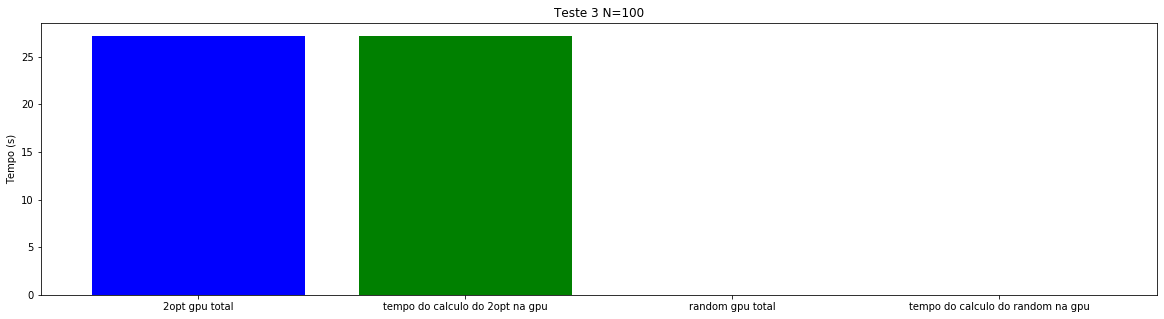

melhor solução: 2-opt 30917.1, random-sol 118542


In [12]:
x = np.arange(4)
y = (np.sin(1.e-2*(x[:-1]-20))+3)**10
mean_list = [np.mean(time_total),np.mean(time_solver),np.mean(time_total_r),np.mean(time_solver_r)]

fig, ax = plt.subplots(figsize=(20,5))
plt.bar(x, mean_list, color = ["blue", "green"])
plt.xticks(x, ["2opt gpu total","tempo do calculo do 2opt na gpu","random gpu total","tempo do calculo do random na gpu","tempo em paralelo"])
plt.ylabel("Tempo (s)")
plt.title("Teste 3 N=100")
plt.show()
print("melhor solução: 2-opt {0}, random-sol {1}".format(best_sol,best_r_sol))

Podemos ver que para exemplos grandes o 2-opt tem um overhead desprezível, já que a grande maioria do tempo (cerca de 99.98%) está sendo gasta para realmente calcular a solução.

## Teste 4

In [ ]:
with open('superlargetest.txt', 'r') as file:
    data = file.read().replace('\n', ' ')
    data = str.encode(data)

time_total = [];
time_solver = [];

for i in range(2):
    main = subprocess.run(["nvprof","./build/2opt-sol"],input = data,stderr=PIPE,stdout=PIPE)
    
    total ,solver = get_time((main.stderr).decode("utf-8"))

    time_total.append(total)
    time_solver.append(solver)
    
time_total_r = [];
time_solver_r = [];

for i in range(4):
    main_r = subprocess.run(["nvprof","./build/random-sol"],input = data,stderr=PIPE,stdout=PIPE)
    
    total ,solver = get_time((main_r.stderr).decode("utf-8"))

    time_total_r.append(total)
    time_solver_r.append(solver)
    

best_sol = ((main.stdout).decode("utf-8")).split()[0]
best_r_sol = ((main_r.stdout).decode("utf-8")).split()[0]

In [ ]:
x = np.arange(4)
y = (np.sin(1.e-2*(x[:-1]-20))+3)**10
mean_list = [np.mean(time_total),np.mean(time_solver),np.mean(time_total_r),np.mean(time_solver_r)]

fig, ax = plt.subplots(figsize=(20,5))
plt.bar(x, mean_list, color = ["blue", "green"] , log=True)
plt.xticks(x, ["2opt gpu total","tempo do calculo do 2opt na gpu","random gpu total","tempo do calculo do random na gpu","tempo em paralelo"])
plt.ylabel("Tempo (s) escala logaritmica")
plt.title("Teste 4 N=300 escala logaritmica")
plt.show()
